## Gradient Boosting

First, we attempt to visualize the dataset.

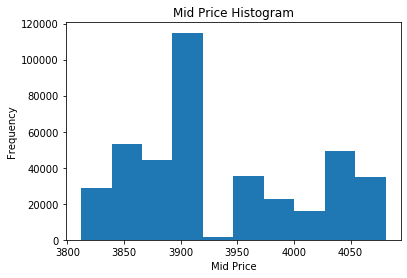

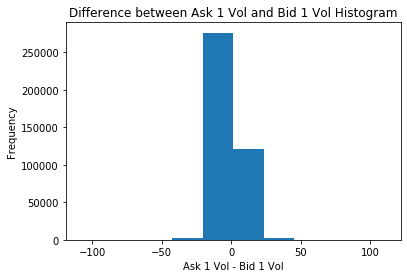

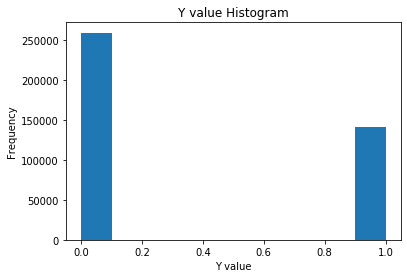

In [0]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import sklearn.metrics
from matplotlib import pyplot as plt

# Load the datasets
train_df = pd.read_csv("train.csv", index_col=0, header=0)
test_df = pd.read_csv("test.csv", index_col=0, header=0)

# Plot the train dataset
plt.hist(train_df.mid)
plt.xlabel("Mid Price")
plt.ylabel("Frequency")
plt.title("Mid Price Histogram")
plt.show()

plt.hist(train_df.ask1vol - train_df.bid1vol)
plt.xlabel("Ask 1 Vol - Bid 1 Vol")
plt.ylabel("Frequency")
plt.title("Difference between Ask 1 Vol and Bid 1 Vol Histogram")
plt.show()

plt.hist(train_df.y)
plt.xlabel("Y value")
plt.ylabel("Frequency")
plt.title("Y value Histogram")
plt.show()

We will try basic gradient boosting for funzies :) using catboost since scikit-learn doesn't take in the appropriate input.

In [0]:
!pip install catboost

     |████████████████████████████████| 64.0MB 50kB/s 


In [0]:
from catboost import CatBoostRegressor as cbr
from catboost import CatBoostClassifier as cbc

# Fill in the missing data with the means of the columns
for col in test_df.columns:
  test_df[col].fillna((test_df[col].mean()), inplace=True)
for col in train_df.columns:
  train_df[col].fillna((train_df[col].mean()), inplace=True)
print(test_df)
print(train_df)

        last_price     mid  opened_position_qty   ...  ask3vol  ask4vol  ask5vol
id                                                ...                           
592380      5178.4  5178.3              1.000000  ...        1        5        2
592381      5133.0  5132.9              1.000000  ...        1        1        1
592382      5177.4  5178.0              2.000000  ...        1        2        5
592383      5093.6  5093.9              0.000000  ...       11        6        2
592384      5189.2  5189.2              1.444629  ...        1        3        4
...            ...     ...                   ...  ...      ...      ...      ...
784234      5150.6  5150.8              1.444629  ...        1        3        2
784235      5122.6  5122.7              1.000000  ...        4        1       16
784236      5192.8  5192.3              1.444629  ...        1        2        1
784237      5152.0  5151.9              4.000000  ...        2        1        1
784238      5200.0  5200.3  

In [0]:
# Train using basic gradient boosting
gb = cbr(learning_rate=0.01, loss_function='RMSE', n_estimators=500, max_depth=4)
gb.fit(train_df[train_df.columns.drop('y')], train_df.y, logging_level='Silent')

In [0]:
# Get the score and predict the testing set
print(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_df[train_df.columns.drop('y')])))
test_df['predicted'] = gb.predict(test_df)
test_df[['predicted']].to_csv('submission.csv')

0.21505996810017264


Sadly this gave us horrible training accuracy. We will definitely need to extract features and build feature importance... Then we can test which features are more likely to affect our evaluations.


In [0]:
# Trying feature extraction by hand. Find bid-ask spreads, price
# differences, mean_prices and volumes
def extract(df):
  ba_spread = []
  ba_diff = []
  ba_mean = []
  ba_accum = []
  for r in range(len(df.index)):
    ba_spread.append([df.ask1.iloc[r] - df.bid1.iloc[r], 
                    df.ask2.iloc[r] - df.bid2.iloc[r],
                    df.ask3.iloc[r] - df.bid3.iloc[r],
                    df.ask4.iloc[r] - df.bid4.iloc[r],
                    df.ask5.iloc[r] - df.bid5.iloc[r]])
    ba_diff.append([df.ask5.iloc[r] - df.ask1.iloc[r], 
                  df.bid1.iloc[r] - df.bid5.iloc[r]])
    mean_vec = [0, 0, 0, 0]
    accum_diff = [0, 0]
    for i in range(1, 6):
      bid_col = "bid" + str(i)
      ask_col = "ask" + str(i)
      bid_vol_col = bid_col + "vol"
      ask_vol_col = ask_col + "vol"
      mean_vec[0] += df[ask_col].iloc[r]
      mean_vec[1] += df[bid_col].iloc[r]
      mean_vec[2] += df[ask_vol_col].iloc[r]
      mean_vec[3] += df[bid_vol_col].iloc[r]
      accum_diff[0] += df[ask_col].iloc[r] - df[bid_col].iloc[r]
      accum_diff[1] += df[ask_vol_col].iloc[r] - df[bid_vol_col].iloc[r]
    mean_vec = [(mean_vec[i] / 4) for i in range(4)]
    ba_mean.append(mean_vec)
    ba_accum.append(accum_diff)

  arr = np.hstack((np.array(ba_spread), np.array(ba_diff), np.array(ba_mean),
                  np.array(ba_accum)))
  extracted = pd.DataFrame(arr, columns = ['baspread1', 'baspread2', 'baspread3',
                                        'baspread4','baspread5', 'askdiff',
                                        'biddiff', 'askmean', 'bidmean', 'askvolmean',
                                        'bidvolmean', 'priceaccum', 'volaccum'])
  return extracted

Re-training with feature extraction...

In [0]:
extract_train = extract(train_df)
extract_test = extract(test_df)
extract_test.index += 592380

In [0]:
train_large = pd.concat([train_df, extract_train], axis=1)
test_large = pd.concat([test_df, extract_test], axis=1)

print(test_large)
print(test_df)

        last_price     mid  ...  priceaccum  volaccum
592380      5178.4  5178.3  ...         5.6     -11.0
592381      5133.0  5132.9  ...         6.2      -1.0
592382      5177.4  5178.0  ...        13.0     -15.0
592383      5093.6  5093.9  ...        11.8       0.0
592384      5189.2  5189.2  ...        11.2       0.0
...            ...     ...  ...         ...       ...
784234      5150.6  5150.8  ...         7.4      -5.0
784235      5122.6  5122.7  ...         5.4      24.0
784236      5192.8  5192.3  ...         9.4       1.0
784237      5152.0  5151.9  ...         5.0     -48.0
784238      5200.0  5200.3  ...        11.0      -3.0

[191859 rows x 39 columns]
        last_price     mid  opened_position_qty   ...  ask3vol  ask4vol  ask5vol
id                                                ...                           
592380      5178.4  5178.3              1.000000  ...        1        5        2
592381      5133.0  5132.9              1.000000  ...        1        1        1


In [0]:
# Train using basic gradient boosting
gb = cbr(learning_rate=0.01, loss_function='RMSE', n_estimators=1000, max_depth=4)
gb.fit(train_large[train_large.columns.drop('y')], train_large.y, logging_level='Silent')
print(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_large[train_large.columns.drop('y')])))

In [0]:
# Predict the testing set
test_large['predicted'] = gb.predict(test_large)
test_large[['predicted']].to_csv('submission.csv')

0.2122184929675075


Unfortunately, gradient boost regressor (catboost's and skilearn's implementation) and ada boost regressor does not achieve high training accuracy. Gradient boost regressor from skilearn (n_estimators=500, max_depth=4, min_samples_split=2, learning_rate=0.01) had a training error of 0.2145. Ada boost regressor (n_estimators=500, learning_rate=0.01, loss='square') had training error of 0.2183.

Let's try dropping some of the features.

In [0]:
train_drop = train_large.drop(['bid2', 'bid3', 'bid4', 'bid5', 'ask2', 'ask3', 'ask4', 'ask5', 
                               'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol'],
                               axis='columns')
test_drop = test_large.drop(['bid2', 'bid3', 'bid4', 'bid5', 'ask2', 'ask3', 'ask4', 'ask5', 
                               'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol'],
                               axis='columns')

print(test_large.columns)
print(test_drop.columns)

Index(['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty',
       'transacted_qty', 'd_open_interest', 'bid1', 'bid2', 'bid3', 'bid4',
       'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5', 'bid1vol', 'bid2vol',
       'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol', 'ask2vol', 'ask3vol',
       'ask4vol', 'ask5vol', 'baspread1', 'baspread2', 'baspread3',
       'baspread4', 'baspread5', 'askdiff', 'biddiff', 'askmean', 'bidmean',
       'askvolmean', 'bidvolmean', 'priceaccum', 'volaccum'],
      dtype='object')
Index(['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty',
       'transacted_qty', 'd_open_interest', 'bid1', 'ask1', 'bid1vol',
       'ask1vol', 'baspread1', 'baspread2', 'baspread3', 'baspread4',
       'baspread5', 'askdiff', 'biddiff', 'askmean', 'bidmean', 'askvolmean',
       'bidvolmean', 'priceaccum', 'volaccum'],
      dtype='object')


In [0]:
# Train using basic gradient boosting
gb = cbr(learning_rate=0.01, loss_function='RMSE', n_estimators=500, max_depth=4)
gb.fit(train_drop[train_drop.columns.drop('y')], train_drop.y, logging_level='Silent')

In [0]:
# Get the score and predict the testing set
print(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_drop[train_drop.columns.drop('y')])))
test_drop['predicted'] = gb.predict(test_drop)
test_drop[['predicted']].to_csv('submission.csv')

0.212312551520472


In [0]:
# Train using basic gradient classifier
gb = cbc(learning_rate=0.1, loss_function='CrossEntropy', l2_leaf_reg=7, n_estimators=1100, max_depth=15)
gb.fit(train_drop[train_drop.columns.drop('y')], train_drop.y, logging_level='Silent')
print(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_drop[train_drop.columns.drop('y')])))

0.10199564830530652


In [0]:
# Predict the testing set
test_drop['predicted'] = gb.predict_proba(test_drop)[:,1]
test_drop[['predicted']].to_csv('submission.csv')

Unfortunately, this did not do much better, so we will now try varying parameters.

Learning rate:0.1
Best error:0.21311924497817697


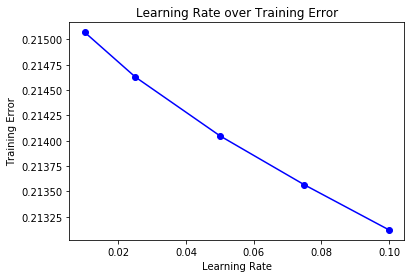

In [0]:
# Test different learning rates
best = [1, 0, 0, 0, 0]
lr = [0.01, 0.025, 0.05, 0.075, 0.1]
error = []
for a in range(len(lr)):
  # Train using basic gradient boosting
  gb = cbr(learning_rate=lr[a], loss_function='RMSE', l2_leaf_reg=0.7, max_depth=4, n_estimators=500)
  gb.fit(train_df[train_df.columns.drop('y')], train_df.y, logging_level='Silent')
  error.append(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_df[train_df.columns.drop('y')])))
  if error[a] <= best[0]:
    best[0] = error[a]
    best[1] = lr[a]

print("Learning rate:" + str(best[1]))
print("Best error:" + str(best[0]))

plt.plot(lr, error, 'bo', linestyle=None)
plt.xlabel("Learning Rate")
plt.ylabel("Training Error")
plt.title("Learning Rate over Training Error")
plt.show()

Reg strength:1
Best error:0.21507105621846778


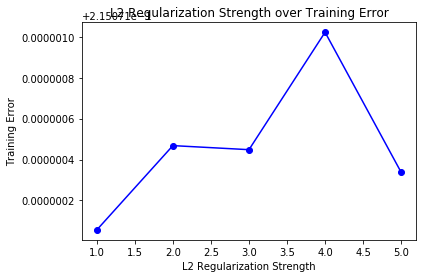

In [0]:
# Test different regularization strengths
leaf = [1, 2, 3, 4, 5]
best[0] = 1
error = []
for b in range(len(leaf)):
  # Train using basic gradient boosting
  gb = cbr(learning_rate=0.01, loss_function='RMSE', l2_leaf_reg=leaf[b], max_depth=4, n_estimators=500)
  gb.fit(train_df[train_df.columns.drop('y')], train_df.y, logging_level='Silent')
  error.append(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_df[train_df.columns.drop('y')])))
  if error[b] <= best[0]:
    best[0] = error[b]
    best[2] = leaf[b]

print("Reg strength:" + str(best[2]))
print("Best error:" + str(best[0]))

plt.plot(leaf, error, 'bo', linestyle=None)
plt.xlabel("L2 Regularization Strength")
plt.ylabel("Training Error")
plt.title("L2 Regularization Strength over Training Error")
plt.show()

Max depth size:15
Best error:0.1928358235134561


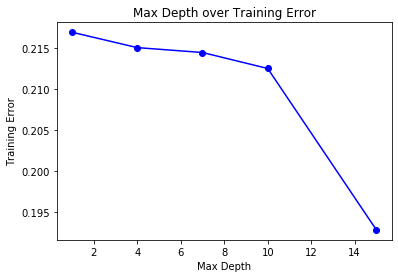

In [0]:
# Test different max depth sizes
depth = [1, 4, 7, 10, 15]
best[0] = 1
error = []
for c in range(len(depth)):
  # Train using basic gradient boosting
  gb = cbr(learning_rate=0.01, loss_function='RMSE', l2_leaf_reg=0.7, max_depth=depth[c], n_estimators=500)
  gb.fit(train_df[train_df.columns.drop('y')], train_df.y, logging_level='Silent')
  error.append(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_df[train_df.columns.drop('y')])))
  if error[c] <= best[0]:
    best[0] = error[c]
    best[3] = depth[c]

print("Max depth size:" + str(best[3]))
print("Best error:" + str(best[0]))

plt.plot(depth, error, 'bo', linestyle=None)
plt.xlabel("Max Depth")
plt.ylabel("Training Error")
plt.title("Max Depth over Training Error")
plt.show()

Number of estimators:1000
Best error:0.2147412321403769


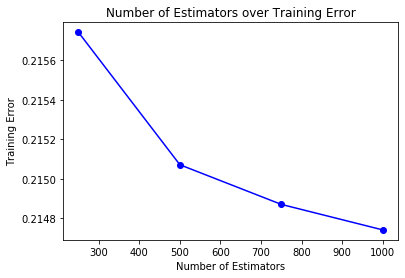

In [0]:
# Test different number of estimators
n_est = [250, 500, 750, 1000]
best[0] = 1
error = []
for d in range(len(n_est)):
  # Train using basic gradient boosting
  gb = cbr(learning_rate=0.01, loss_function='RMSE', l2_leaf_reg=0.7, max_depth=4, n_estimators=n_est[d])
  gb.fit(train_df[train_df.columns.drop('y')], train_df.y, logging_level='Silent')
  error.append(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_df[train_df.columns.drop('y')])))
  if error[d] <= best[0]:
    best[0] = error[d]
    best[4] = n_est[d]

print("Number of estimators:" + str(best[4]))
print("Best error:" + str(best[0]))

plt.plot(n_est, error, 'bo', linestyle=None)
plt.xlabel("Number of Estimators")
plt.ylabel("Training Error")
plt.title("Number of Estimators over Training Error")
plt.show()

Now that we have our best parameters, we will try using cross-validation with these.

In [0]:
# Cross Validation
best = [0, 0.1, 5, 15, 1250]
result = []
errors = []
for i in range(5): 
  indices = np.arange(train_large.index.size)
  fin_indices = indices + np.repeat(i, len(indices))
  if indices[len(indices) - 1] >= train_large.index.size:
    indices[len(indices) - 1] = i
  train = train_large.iloc[np.mod(fin_indices, 5)!=0]
  val = train_large.iloc[np.mod(fin_indices, 5) == 0]
  # Train using gradient boosting with the best parameters
  gb = cbr(learning_rate=best[1], loss_function='RMSE', l2_leaf_reg=best[2], max_depth=best[3], n_estimators=best[4])
  gb.fit(train[train.columns.drop('y')], train.y, logging_level='Silent', 
         eval_set=(val[val.columns.drop('y')], val.y), use_best_model=True)
  result.append(gb.predict(test_large))
  errors.append(sklearn.metrics.mean_squared_error(train.y, gb.predict(train[train.columns.drop('y')])))
error = np.mean(np.array(errors))
print(error)

KeyboardInterrupt: ignored

In [0]:
# Average the predictions of the testing set
test_large['predicted'] = np.mean(np.array(result), axis=0)
test_large[['predicted']].to_csv('submission.csv')

This did not give us that much better testing accuracy, though we did get a training error of 0.10, indicating possible overfitting. Thus, we will try to use a classifier instead of a regressor.

In [0]:
# Train using basic gradient classifier
gb = cbc(learning_rate=0.01, loss_function='Logloss', n_estimators=1000, max_depth=4)
gb.fit(train_large[train_large.columns.drop('y')], train_large.y, logging_level='Silent')
print(sklearn.metrics.mean_squared_error(train_df.y, gb.predict(train_large[train_large.columns.drop('y')])))

0.3346368478377361


In [0]:
# Predict the testing set
test_large['predicted'] = gb.predict_proba(test_large)[:,1]
test_large[['predicted']].to_csv('submission.csv')

In [0]:
# Cross Validation
best = [0, 0.1, 5, 15, 500]
result = []
errors = []
for i in range(5): 
  print(i)
  indices = np.arange(train_large.index.size)
  fin_indices = indices + np.repeat(i, len(indices))
  if indices[len(indices) - 1] >= train_large.index.size:
    indices[len(indices) - 1] = i
  train = train_large.iloc[np.mod(fin_indices, 5)!=0]
  val = train_large.iloc[np.mod(fin_indices, 5) == 0]
  # Train using gradient boosting with the best parameters
  gb = cbc(learning_rate=best[1], loss_function='Logloss', l2_leaf_reg=best[2],
           max_depth=best[3], n_estimators=best[4])
  gb.fit(train[train.columns.drop('y')], train.y, logging_level='Silent', 
         eval_set=(val[val.columns.drop('y')], val.y), use_best_model=True)
  result.append(gb.predict_proba(test_large[test_large.columns.drop('predicted')])[:,1])
  errors.append(sklearn.metrics.mean_squared_error(train.y, gb.predict(train[train.columns.drop('y')])))
error = np.mean(np.array(errors))
print(error)

0
1
2
3
4
0.14100013778165715


In [0]:
# Average the predictions of the testing set
test_large['predicted'] = np.mean(np.array(result), axis=0)
test_large[['predicted']].to_csv('submission.csv')

# Get feature importance
print(train_large.columns)
print(gb.get_feature_importance())

Index(['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty',
       'transacted_qty', 'd_open_interest', 'bid1', 'bid2', 'bid3', 'bid4',
       'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5', 'bid1vol', 'bid2vol',
       'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol', 'ask2vol', 'ask3vol',
       'ask4vol', 'ask5vol', 'y', 'baspread1', 'baspread2', 'baspread3',
       'baspread4', 'baspread5', 'askdiff', 'biddiff', 'askmean', 'bidmean',
       'askvolmean', 'bidvolmean', 'priceaccum', 'volaccum'],
      dtype='object')
[0.76604062 0.87577365 2.88977667 2.88736754 3.80667876 1.51040396
 0.42986539 0.24264999 0.38949198 0.52736725 0.5905904  0.66837702
 0.41011935 0.49748543 0.36032129 0.66346993 6.72303871 5.50385126
 5.00557291 5.12840713 5.53016826 8.13687959 6.07767599 5.04725648
 4.7753556  5.16138372 3.80094835 1.93278907 0.83680063 1.2546283
 1.14494291 3.44118018 3.08584646 0.62994029 0.51053629 2.74715015
 2.42332803 1.6602758  1.92626467]


We thus find that using gradient boosting classifier works the best.